# Handwritten digit recognition using Adversarial Autoencoder

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import os
import math
import torch.optim as optim
from IPython import display
import itertools
import matplotlib.pyplot as plt

In [3]:
# MNIST Dataset 
dataset = dsets.MNIST(root='./MNIST', train=True, transform=transforms.ToTensor(),  download=True)
testset = dsets.MNIST(root='./MNIST', train=False, transform=transforms.ToTensor(),  download=True)

# Data Loader (Input Pipeline)
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=100, shuffle=True)

In [4]:
def to_np(x):
    return x.data.cpu().numpy()

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x) 

def to_cuda(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return x

In [5]:
#Encoder
class Q_net(nn.Module):  
    def __init__(self,X_dim,N,z_dim):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3gauss = nn.Linear(N, z_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = F.relu(x)
        xgauss = self.lin3gauss(x)
        return xgauss

# Decoder
class P_net(nn.Module):  
    def __init__(self,X_dim,N,z_dim):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = self.lin3(x)
        return F.sigmoid(x)

# Discriminator
class D_net_gauss(nn.Module):  
    def __init__(self,N,z_dim):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 1)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)
        return F.sigmoid(self.lin3(x))

In [6]:
z_red_dims = 2
Q = to_cuda(Q_net(784,1000,z_red_dims))
P = to_cuda(P_net(784,1000,z_red_dims))
D_gauss = to_cuda(D_net_gauss(500,z_red_dims))


# Set learning rates
gen_lr = 0.0001
reg_lr = 0.00005

#encode/decode optimizers
optim_P = optim.Adam(P.parameters(), lr=gen_lr)
optim_Q_enc = optim.Adam(Q.parameters(), lr=gen_lr)
#regularizing optimizers
optim_Q_gen = optim.Adam(Q.parameters(), lr=reg_lr)
optim_D = optim.Adam(D_gauss.parameters(), lr=reg_lr)

In [7]:
num_test_samples = 100

test_noise = torch.Tensor(num_test_samples,z_red_dims)
p = [-1,1,-1,1]
q = [-1,1,1,-1]
for loop in range(4):
    
    for i in range(5):
        for j in range(5):
            test_noise[25*loop+i*5+j] = torch.Tensor([(i+1)*0.4*p[loop], (j+1)*0.4*q[loop]])


test_noise = to_var(test_noise)

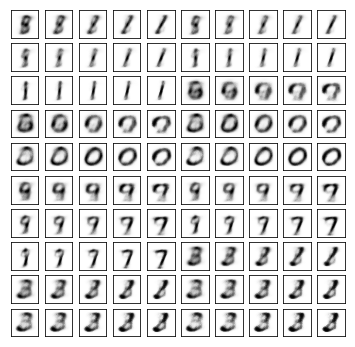

In [ ]:
# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    
    
data_iter = iter(data_loader)
iter_per_epoch = len(data_loader)
total_step = 5000

# Start training
for step in range(total_step):

    # Reset the data_iter
    if (step+1) % iter_per_epoch == 0:
        data_iter = iter(data_loader)

    # Fetch the images and labels and convert them to variables
    images, labels = next(data_iter)
    images, labels = to_var(images.view(images.size(0), -1)), to_var(labels)

    #reconstruction loss
    P.zero_grad()
    Q.zero_grad()
    D_gauss.zero_grad()

    z_sample = Q(images)   #encode to z
    X_sample = P(z_sample) #decode to X reconstruction
    recon_loss = F.binary_cross_entropy(X_sample,images)

    recon_loss.backward()
    optim_P.step()
    optim_Q_enc.step()

    # Discriminator
    ## true prior is random normal (randn)
    ## this is constraining the Z-projection to be normal!
    Q.eval()
    z_real_gauss = to_var(torch.randn(images.size()[0], z_red_dims))
    D_real_gauss = D_gauss(z_real_gauss)

    z_fake_gauss = Q(images)
    D_fake_gauss = D_gauss(z_fake_gauss)

    D_loss = -torch.mean(torch.log(D_real_gauss) + torch.log(1 - D_fake_gauss))

    D_loss.backward()
    optim_D.step()

    # Generator
    Q.train()
    z_fake_gauss = Q(images)
    D_fake_gauss = D_gauss(z_fake_gauss)
    
    G_loss = -torch.mean(torch.log(D_fake_gauss))

    G_loss.backward()
    optim_Q_gen.step()   
    
    P.eval()
    test_images = P(test_noise)
    P.train()
            
    for k in range(num_test_samples):
        i = k//10
        j = k%10
        ax[i,j].cla()
        ax[i,j].imshow(to_np(test_images[k,:]).reshape(28, 28), cmap='Greys')
    display.clear_output(wait=True)
    display.display(plt.gcf())